# Single sample intracellular signalling network inference

In this notebook we showcase how to use the advanced CARNIVAL implementation available in CORNETO. This implementation extends the capabilities of the original CARNIVAL method by enabling advanced modelling and injection of knowledge for hypothesis generation. We will use a dataset consisting of 6 samples of hepatic stellate cells (HSC) where three of them were activated by the cytokine Transforming growth factor (TGF-β). 

In the first part, we will show how to estimate Transcription Factor activities from gene expression data, following the [Decoupler tutorial](https://decoupler-py.readthedocs.io/en/latest/notebooks/bulk.html) for functional analysis. Then, we will use the CARNIVAL method available in CORNETO to infer a network from TFs to receptors, assuming that we don't really know which treatment was used.

In [1]:
# --- Saezlab tools ---
# https://decoupler-py.readthedocs.io/
import gzip
import os
import shutil
import tempfile
import urllib.request

import decoupler as dc
import numpy as np

# https://omnipathdb.org/
import omnipath as op

# Additional packages
import pandas as pd

# --- Additional libs ---
# Pydeseq for differential expression analysis
from pydeseq2.dds import DefaultInference, DeseqDataSet
from pydeseq2.ds import DeseqStats

# https://saezlab.github.io/
import corneto as cn

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
max_time = 300
seed = 0

In [3]:
# We need to download the dataset, available at GEO GSE151251
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz"

adata = None
with tempfile.TemporaryDirectory() as tmpdirname:
    # Path for the gzipped file in the temp folder
    gz_file_path = os.path.join(tmpdirname, "counts.txt.gz")

    # Download the file
    with urllib.request.urlopen(url) as response:
        with open(gz_file_path, "wb") as out_file:
            shutil.copyfileobj(response, out_file)

    # Decompress the file
    decompressed_file_path = gz_file_path[:-3]  # Removing '.gz' extension
    with gzip.open(gz_file_path, "rb") as f_in:
        with open(decompressed_file_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    adata = pd.read_csv(decompressed_file_path, index_col=2, sep="\t").iloc[:, 5:].T

adata

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


## Data preprocessing

We will use AnnData and PyDeseq2 to pre-process the data and compute differential expression between control and tretament

In [4]:
from anndata import AnnData

adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

/Users/pablorodriguezmier/miniforge3/envs/corneto-fork/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pablorodriguezmier/miniforge3/envs/corneto-fork/lib/python3.12/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


AnnData object with n_obs × n_vars = 6 × 64253

In [5]:
# Process treatment information
adata.obs["condition"] = [
    "control" if "-Ctrl" in sample_id else "treatment" for sample_id in adata.obs.index
]

# Process sample information
adata.obs["sample_id"] = [sample_id.split("_")[0] for sample_id in adata.obs.index]

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


In [6]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(
    adata, group="condition", min_count=10, min_total_count=15, large_n=1, min_prop=1
)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 19713
    obs: 'condition', 'sample_id'

In [7]:
# Estimation of differential expression

inference = DefaultInference()
dds = DeseqDataSet(
    adata=adata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_97851/4244457668.py:4: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [8]:
# Compute LFCs
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.65 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 0.82 seconds.

Fitting LFCs...
... done in 0.46 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.



In [9]:
stat_res = DeseqStats(
    dds, contrast=["condition", "treatment", "control"], inference=inference
)

stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition treatment vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
WASH7P           10.349784       -0.011139  0.651659 -0.017093  0.986362   
MIR6859-1        10.114621        0.000646  0.657316  0.000982  0.999216   
RP11-34P13.7     45.731312        0.078207  0.324393  0.241087  0.809487   
RP11-34P13.8     29.498379       -0.065184  0.393560 -0.165626  0.868451   
CICP27          106.032659        0.150600  0.222955  0.675471  0.499377   
...                    ...             ...       ...       ...       ...   
MT-ND6        17914.984474       -0.435304  0.278796 -1.561372  0.118436   
MT-TE          1281.293477       -0.332495  0.288073 -1.154204  0.248416   
MT-CYB        54955.449372       -0.313285  0.286900 -1.091966  0.274848   
MT-TT           204.692221       -0.485883  0.220564 -2.202915  0.027601   
MT-TP           345

... done in 0.35 seconds.



In [10]:
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
WASH7P,10.349784,-0.011139,0.651659,-0.017093,0.986362,0.991392
MIR6859-1,10.114621,0.000646,0.657316,0.000982,0.999216,0.999509
RP11-34P13.7,45.731312,0.078207,0.324393,0.241087,0.809487,0.877264
RP11-34P13.8,29.498379,-0.065184,0.393560,-0.165626,0.868451,0.917051
CICP27,106.032659,0.150600,0.222955,0.675471,0.499377,0.637262
...,...,...,...,...,...,...
MT-ND6,17914.984474,-0.435304,0.278796,-1.561372,0.118436,0.210925
MT-TE,1281.293477,-0.332495,0.288073,-1.154204,0.248416,0.380027
MT-CYB,54955.449372,-0.313285,0.286900,-1.091966,0.274848,0.411208


## Prior knowledge with Decoupler and Omnipath

In [11]:
# Retrieve CollecTRI gene regulatory network (through Omnipath)
collectri = dc.get_collectri(organism="human", split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [12]:
mat = results_df[["stat"]].T.rename(index={"stat": "treatment.vs.control"})
mat

GeneName,WASH7P,MIR6859-1,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,-0.017093,0.000982,0.241087,-0.165626,0.675471,-1.646005,2.042031,-0.376975,-1.994364,-0.498507,...,-1.435973,0.75501,1.139089,1.167108,-1.242582,-1.561372,-1.154204,-1.091966,-2.202915,-2.84928


In [13]:
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 19713 targets for 655 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
treatment.vs.control,-2.179559,-1.561975,-1.822945,-1.981524,-2.67045,0.21549,-3.931481,0.870412,1.648694,-0.611922,...,-0.062613,2.121308,1.886897,-1.14056,-1.571203,-1.276569,-0.116815,3.373271,0.86042,-2.742784


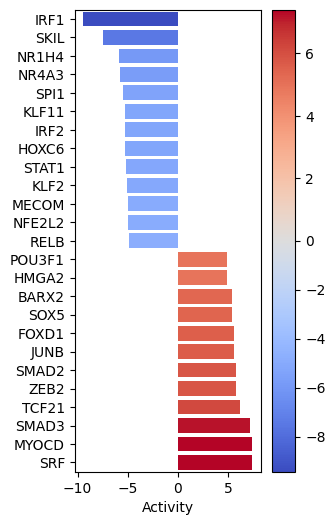

In [14]:
dc.plot_barplot(
    acts=tf_acts, contrast="treatment.vs.control", top=25, vertical=True, figsize=(3, 6)
)

In [15]:
# We obtain ligand-receptor interactions from Omnipath, and we keep only the receptors
# This is our list of a prior potential receptors from which we will infer the network
unique_receptors = set(
    op.interactions.LigRecExtra.get(genesymbols=True)[
        "target_genesymbol"
    ].values.tolist()
)
len(unique_receptors)

1201

<Axes: xlabel='log2FoldChange', ylabel='stat'>

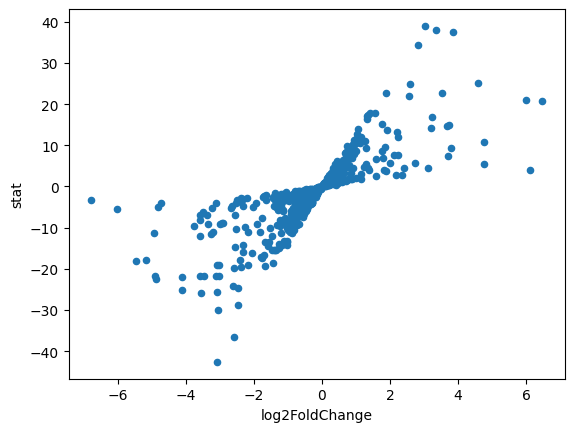

In [16]:
df_de_receptors = results_df.loc[results_df.index.intersection(unique_receptors)]
df_de_receptors = df_de_receptors.sort_values(by="stat", ascending=False)
df_de_receptors.plot.scatter(x="log2FoldChange", y="stat")

In [17]:
# We will take the top 20 receptors that increased the expression after treatment
df_top_receptors = df_de_receptors.head(20)
df_top_receptors

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
CDH6,28262.296983,3.019806,0.077448,38.991476,0.000000e+00,0.000000e+00
CRLF1,7919.672343,3.341645,0.088026,37.962070,0.000000e+00,0.000000e+00
FZD8,2719.781498,3.843017,0.102718,37.413242,2.380145e-306,2.469463e-303
CDH2,7111.507547,2.809462,0.081958,34.279439,1.589168e-257,9.213903e-255
DYSF,441.449511,4.593250,0.182196,25.210487,3.073961e-140,5.362566e-138
INHBA,24329.359641,2.598613,0.104350,24.902821,6.934669e-137,1.139193e-134
CELSR1,492.324435,3.517315,0.154487,22.767746,9.574546e-115,1.258287e-112
PDGFC,5481.167075,1.894858,0.083837,22.601620,4.177614e-113,5.453862e-111
VDR,1450.304353,2.555008,0.116797,21.875720,4.424761e-106,5.286382e-104


## Inferring intracellular signalling network with CARNIVAL and CORNETO

CORNETO is a unified framework for knowledge-driven network inference. It includes a very flexible implementation of CARNIVAL that expands its original capabilities. We will see how to use it under different assumptions to extract a network from a prior knowledge network and a set of potential receptors + our estimated TFs


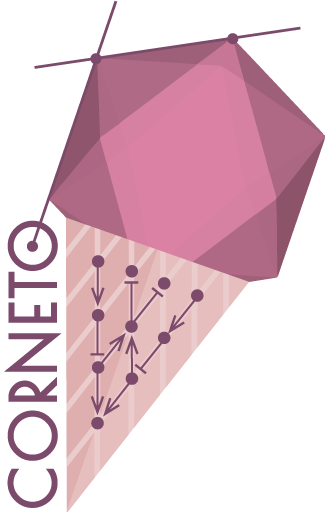

In [18]:
cn.info()

In [19]:
# We get only interactions from SIGNOR http://signor.uniroma2.it/
pkn = op.interactions.OmniPath.get(databases=["SIGNOR"], genesymbols=True)
pkn = pkn[pkn.consensus_direction == True]
pkn.head()

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,Q13976,Q13507,PRKG1,TRPC3,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
1,Q13976,Q9HCX4,PRKG1,TRPC7,True,True,False,True,True,False,3,SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151,SIGNOR;TRIP;iPTMnet,3,3,1,21402151
2,Q13438,Q9HBA0,OS9,TRPV4,True,True,True,True,True,True,3,HPRD:17932042;SIGNOR:17932042;TRIP:17932042,HPRD;SIGNOR;TRIP,3,3,1,17932042
3,P18031,Q9H1D0,PTPN1,TRPV6,True,False,True,True,False,True,11,DEPOD:15894168;DEPOD:17197020;HPRD:15894168;In...,DEPOD;HPRD;IntAct;Lit-BM-17;SIGNOR;SPIKE_LC;TRIP,7,6,2,15894168;17197020
4,P63244,Q9BX84,RACK1,TRPM6,True,False,True,True,False,True,2,SIGNOR:18258429;TRIP:18258429,SIGNOR;TRIP,2,2,1,18258429


In [20]:
pkn["interaction"] = pkn["is_stimulation"].astype(int) - pkn["is_inhibition"].astype(
    int
)
sel_pkn = pkn[["source_genesymbol", "interaction", "target_genesymbol"]]
sel_pkn

,source_genesymbol,interaction,target_genesymbol
0,PRKG1,-1,TRPC3
1,PRKG1,1,TRPC7
2,OS9,0,TRPV4
3,PTPN1,-1,TRPV6
4,RACK1,-1,TRPM6
...,...,...,...
61542,APC_PUF60_SIAH1_SKP1_TBL1X,-1,CTNNB1
61543,MAP2K6,1,MAPK10
61544,PRKAA1,1,TP53
61545,CNOT1_CNOT10_CNOT11_CNOT2_CNOT3_CNOT4_CNOT6_CN...,-1,NANOS2


In [21]:
# We create the CORNETO graph by importing the edges and interaction
from corneto.graph import Graph
from corneto.io import load_graph_from_sif_tuples
G = load_graph_from_sif_tuples(
    [(r[0], r[1], r[2]) for _, r in sel_pkn.iterrows() if r[1] != 0]
)
G.shape

(5442, 60034)

In [22]:
# As measurements, we take the estimated TFs, we will filter out TFs with p-val > 0.001
significant_tfs = (
    tf_acts[tf_pvals <= 0.001]
    .T.dropna()
    .sort_values(by="treatment.vs.control", ascending=False)
)
significant_tfs

,treatment.vs.control
SRF,7.402565
MYOCD,7.366407
SMAD3,7.205507
TCF21,6.178324
ZEB2,5.804123
...,...
SPI1,-5.442575
NR4A3,-5.745412
NR1H4,-5.917429
SKIL,-7.463470


In [23]:
# We keep only the ones in the PKN graph
measurements = significant_tfs.loc[significant_tfs.index.intersection(G.V)].to_dict()[
    "treatment.vs.control"
]
measurements

{'SRF': 7.402564525604248,
 'MYOCD': 7.36640739440918,
 'SMAD3': 7.205506801605225,
 'ZEB2': 5.8041229248046875,
 'SMAD2': 5.7937397956848145,
 'JUNB': 5.62872314453125,
 'HMGA2': 4.934858322143555,
 'POU3F1': 4.918986797332764,
 'RORA': 4.76252555847168,
 'SMAD4': 4.730061054229736,
 'MEF2A': 4.285721302032471,
 'FGF2': 4.222509860992432,
 'FOSL1': 3.9362800121307373,
 'SOX4': 3.92212176322937,
 'NCOA1': 3.8224685192108154,
 'ASXL1': 3.7563669681549072,
 'SFPQ': 3.7415316104888916,
 'FOSB': 3.7254574298858643,
 'SP7': 3.695308208465576,
 'CREB3': 3.6301043033599854,
 'NFATC3': 3.5302765369415283,
 'MEIS2': 3.4903156757354736,
 'ZNF804A': 3.3732707500457764,
 'TAL1': 3.353253126144409,
 'DLX5': 3.33522367477417,
 'DLX2': -3.2915139198303223,
 'CDX2': -3.296456813812256,
 'CEBPG': -3.307525396347046,
 'MAFA': -3.3084702491760254,
 'NFIB': -3.3599045276641846,
 'NFKB1': -3.4378252029418945,
 'RXRB': -3.4568121433258057,
 'STAT5A': -3.5282504558563232,
 'MSX2': -3.5356292724609375,
 'PLAG

In [24]:
# We will infer the direction, so for the inputs, we use a value of 0 (=unknown direction)
inputs = {k: 0 for k in df_top_receptors.index.intersection(G.V).values}
inputs

{'CDH6': 0,
 'CRLF1': 0,
 'FZD8': 0,
 'CDH2': 0,
 'INHBA': 0,
 'VDR': 0,
 'IGF1': 0,
 'EFNB2': 0,
 'ITGB3': 0,
 'TGFB1': 0,
 'IL21R': 0,
 'EGF': 0,
 'ITGA11': 0}

In [25]:
# Create the dataset in standard format
carnival_data = dict()
for inp, v in inputs.items():
    carnival_data[inp] = dict(value=v, role="input", mapping="vertex")
for out, v in measurements.items():
    carnival_data[out] = dict(value=v, role="output", mapping="vertex")
data = cn.Data.from_cdict({"sample1": carnival_data})
data

Data(n_samples=1, n_feats=[77])

In [30]:
from corneto.methods.future import CarnivalFlow

carnival = CarnivalFlow(lambda_reg=0.5)
P = carnival.build(G, data)
P.expr

Unreachable vertices for sample: 0


{'_flow': Variable((3374,), _flow),
 'edge_inhibits': Variable((3374, 1), edge_inhibits, boolean=True),
 'edge_activates': Variable((3374, 1), edge_activates, boolean=True),
 'const0x1930e02eaa686dd1': Constant(CONSTANT, NONNEGATIVE, (970, 3374)),
 '_dag_layer': Variable((970, 1), _dag_layer),
 'const0x10dea3c6fa83e90b': Constant(CONSTANT, NONNEGATIVE, (970, 3374)),
 'flow': Variable((3374,), _flow),
 'vertex_value': Expression(AFFINE, UNKNOWN, (970, 1)),
 'vertex_activated': Expression(AFFINE, NONNEGATIVE, (970, 1)),
 'vertex_inhibited': Expression(AFFINE, NONNEGATIVE, (970, 1)),
 'edge_value': Expression(AFFINE, UNKNOWN, (3374, 1)),
 'edge_has_signal': Expression(AFFINE, NONNEGATIVE, (3374, 1))}

In [31]:
P.solve(solver="highs", verbosity=1);

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 08 09:51:11 AM: Your problem has 11092 variables, 31652 constraints, and 1 parameters.
(CVXPY) Apr 08 09:51:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 08 09:51:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 08 09:51:11 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 08 09:51:11 AM: Compiling problem (target solver=HIGHS).
(CVXPY) Apr 08 09:51:11 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> HIGHS
(CVXPY) Apr 08 09:51:11 A

In [32]:
for o in P.objectives:
    print(o.value)

7.0169713497161865
92.0


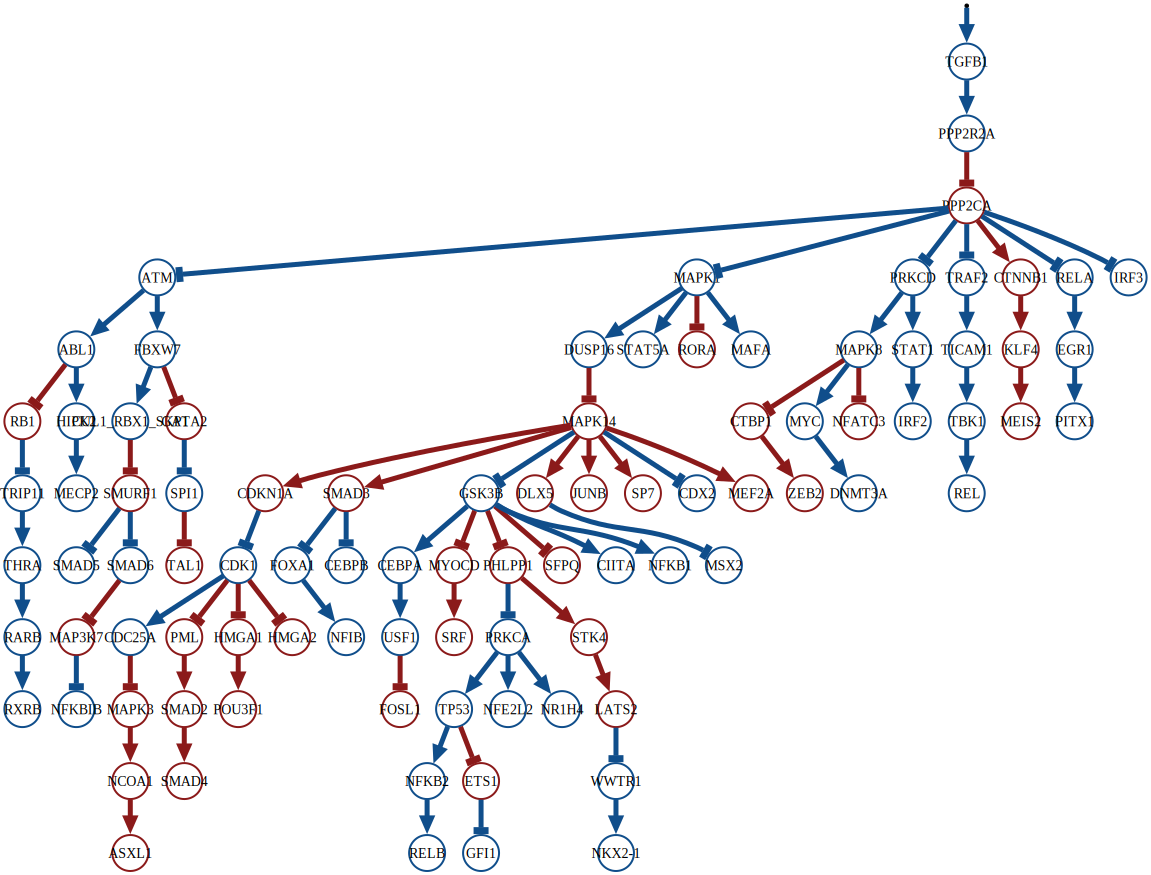

In [33]:
# We extract the selected edges
sol_edges = np.flatnonzero(np.abs(P.expr.edge_value.value) > 0.5)
carnival.processed_graph.plot_values(
    vertex_values = P.expr.vertex_value.value,
    edge_values = P.expr.edge_value.value,
    edge_indexes = sol_edges
)

In [ ]:
# The CARNIVAL problem can be manipulated for hypothesis exploration.
# For example, we will say that only 1 of the provided receptors has to be selected, at most.
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)
idx_receptors = [vertices.index(k) for k in inputs_p.keys()]
protein_selected = P.expr.vertex_activated + P.expr.vertex_inhibited
P += sum(protein_selected[idx_receptors]) == 1
P.solve(solver="GUROBI", TimeLimit=max_time, Seed=seed);

In [ ]:
# We extract the edges that have some signal (edge_values != 0)
# We select the sub-graph from the processed PKN
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))

# We plot generating custom drawing attributes
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(
    custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(
        G_sol.V, vertex_sol_values
    )
)

In [ ]:
# Print the values of the objectives:
# - First objective is error (non-fited TFs).
# - Second objective is number of interactions
for o in P.objectives:
    print(o.value)

## Adding more knowledge

We can add more prior knowledge to the CARNIVAL problem. For example, we are going to penalise genes that are lowly abundant, according to the average basal gene expression levels. 

In [ ]:
df_lowly_abundant_genes = results_df[
    (results_df.baseMean <= results_df.baseMean.quantile(0.25))
    & (results_df.padj >= 0.05)
]
df_lowly_abundant_genes.sort_values(by="padj")

In [ ]:
lowly_abundant_genes = set(Gp.V).intersection(df_lowly_abundant_genes.index.tolist())
lowly_abundant_genes, len(lowly_abundant_genes)

In [ ]:
# Now we will add a penalty to avoid selecting lowly expressed genes
vertices = Gp.V
penalties = np.zeros(Gp.num_vertices)
penalties[[vertices.index(v) for v in lowly_abundant_genes.intersection(vertices)]] = (
    0.01
)
penalties

In [ ]:
# Create the carnival problem
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)

# We penalize the inclusion of lowly expressed genes:
# protein_selected is just the sum of the binary variables vertex activated and vertex inhibited, defined in carnival.
# these variables are mutually exclusive, so the sum is at most 1, meaning that the vertex was selected, either activated (+1) or inhibited (-1)
protein_selected = P.expr.vertex_activated + P.expr.vertex_inhibited

# We multiply the vector variable of selected proteins and the penalties to
# sum the total cost: sum (v1 * penalty1 + v2 * penalty2, + v3 ...) and we add this as an objective
penalty_vertices = protein_selected @ penalties
P.add_objectives(penalty_vertices)

# Select only 1 receptor
protein_selected = P.expr.vertex_activated + P.expr.vertex_inhibited
# P += sum(protein_selected[idx_receptors]) == 1

P.solve(solver="GUROBI", Seed=seed, TimeLimit=max_time);

In [ ]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(
    custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(
        G_sol.V, vertex_sol_values
    )
)

In [ ]:
# Print the values of the objectives:
for o in P.objectives:
    print(o.value)

In [ ]:
# Now we are going to force that only TGFB1 (active)
Gp, inputs_p, measurements_p = preprocess_graph(G, {"TGFB1": 1}, measurements)
Gp.shape

In [ ]:
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)
P.solve(solver="GUROBI", Seed=seed, TimeLimit=max_time);

In [ ]:
# Same error but +2 edges were included to explain the TFs
for o in P.objectives:
    print(o.value)

In [ ]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(
    custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(
        G_sol.V, vertex_sol_values
    )
)

In [ ]:
# Biasing the networks towards activatory interactions

# Create the carnival problem with Beta = 0 (to not equally penalise all interactions)
# Gp, inputs_p, measurements_p = preprocess_graph(G, {"TGFB1": 0}, measurements)
Gp, inputs_p, measurements_p = preprocess_graph(G, inputs, measurements)
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0)

# Bias towards activations, by penalizing only inhibitions
P.add_objectives(P.expr.edge_inhibiting.sum(), weights=0.2)

# Much smaller penalty for activations, since we only want to penalise them
# slightly to avoid having spurious interactions. However, inhibitions are
# penalised 20x more than activations (weight 0.2 vs 0.01)
P.add_objectives(P.expr.edge_activating.sum(), weights=0.01)

P.solve(solver="GUROBI", TimeLimit=max_time, Seed=seed);

In [ ]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(
    custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(
        G_sol.V, vertex_sol_values
    )
)

In [ ]:
# 48 inhibitory interactions and 44 activations
for o in P.objectives:
    print(o.value)

We have explored different approaches and assumptions to recover a signalling network from TF activities and a list of potential receptors. Although changes in gene expression for signalling proteins are not always predictive of signalling cascades—hence the use of CARNIVAL as a footprint-based method to bridge the gaps between receptors and TFs—we can introduce a slight bias in the network towards signalling proteins whose gene expression has changed significantly after treatment. These changes, while indirect, may still provide valuable cues. In a manner similar to how we penalised low-abundance genes, we will now prioritize the inclusion of upregulated genes.

In [ ]:
tf_acts.columns

In [ ]:
# Since the problem minimises error, we change sign. Upregulated genes get negative score
# so if they are selected, the error decreases. The opposite for downregulated genes
df_gene_scores = -results_df.loc[
    results_df.index.intersection(Gp.V).difference(tf_acts.columns)
].stat
dict_scores = df_gene_scores.to_dict()

df_gene_scores.sort_values()

In [ ]:
# Now we will add a penalty to avoid selecting lowly expressed genes
vertices = Gp.V
scores = np.array([dict_scores.get(v, 0) for v in vertices])
np.sum(np.abs(scores))

In [ ]:
# Create the carnival problem
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)
vertex_selected = P.expr.vertex_activated + P.expr.vertex_inhibited
total_score = vertex_selected @ scores
P.add_objectives(total_score, weights=1e-3)
P.solve(solver="GUROBI", Seed=seed, TimeLimit=max_time);

In [ ]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(
    custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(
        G_sol.V, vertex_sol_values
    )
)

In [ ]:
for o in P.objectives:
    print(o.value)